# Abstract Classification Model with GRU

#0. Install and import packages

In [ ]:
!pip install gensim==4.2.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os.path
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import nltk
from nltk.corpus import brown, stopwords
from gensim.models import Word2Vec, KeyedVectors, fasttext
from tqdm import tqdm


# use gpu if possible
device = "cuda" if torch.cuda.is_available() else "cpu"
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 1. Load embedding

Load the embedding by using Gensim. Examine the shape of the vectors.

In [ ]:
def load_fasttext(file_path):
    ft_model = fasttext.load_facebook_vectors(
        file_path + 'embeddings/cc.en.100.bin') 
    return ft_model


def load_glove(file_path):
    word2vec_model = KeyedVectors.load_word2vec_format(
        file_path + 'embeddings/glove.6B.50d.txt',
        binary=False,
        unicode_errors='ignore',
        encoding='utf-8')
    return word2vec_model


def load_google(file_path):
    google_model = KeyedVectors.load(
        file_path + 'embeddings/word2vec-google-news-300.model')
    return google_model


w2v = load_google(folder_path)


In [ ]:
# check dimension and length
embedding_dim = len(w2v.vectors[0])
embedding_dim, len(w2v)


(300, 3000000)

# 2. Data exploration and preprocessing

In [ ]:
# load csv using pandas
# ignore the 'path' column
df = pd.read_csv(folder_path + 'mesh.csv', usecols=['label', 'Text'])
df.head()


,label,Text
0,Conjunctival Diseases,a white north american girl with clinical feat...
1,Conjunctival Diseases,sixteen patients with an unusual and distinct ...
2,Conjunctival Diseases,"a molluscum contagiosum nodule, situated at th..."
3,Conjunctival Diseases,a white male infant of 1 year had unilateral m...
4,Conjunctival Diseases,a case of primary meningococcal conjunctivitis...


In [ ]:
df.shape


(27074, 2)

In [ ]:
# check if there is any nulls
df.isnull().sum()


label    0
Text     1
dtype: int64

In [ ]:
# drop the row that has null for text
df.dropna(inplace=True)
df.isnull().sum()


label    0
Text     0
dtype: int64

In [ ]:
# create a dictionary with indices as key and labels as values
unique_label_array = df['label'].unique()
label_dict = dict(enumerate(unique_label_array))
label_dict


{0: 'Conjunctival Diseases',
 1: 'Corneal Diseases',
 2: 'Eye Abnormalities',
 3: 'Eye Diseases, Hereditary',
 4: 'Eye Hemorrhage',
 5: 'Eye Infections',
 6: 'Eye Injuries',
 7: 'Eye Neoplasms',
 8: 'Eyelid Diseases',
 9: 'Lacrimal Apparatus Diseases',
 10: 'Lens Diseases',
 11: 'Ocular Hypertension',
 12: 'Ocular Motility Disorders',
 13: 'Optic Nerve Diseases',
 14: 'Orbital Diseases',
 15: 'Pupil Disorders',
 16: 'Refractive Errors',
 17: 'Retinal Diseases',
 18: 'Scleral Diseases',
 19: 'Uveal Diseases',
 20: 'Vision Disorders'}

In [ ]:
# replace the labels with indices
val_to_key = lambda x: [k for k, v in label_dict.items() if v==x][0]
df['label'] = df['label'].apply(val_to_key)
df.head()


,label,Text
0,0,a white north american girl with clinical feat...
1,0,sixteen patients with an unusual and distinct ...
2,0,"a molluscum contagiosum nodule, situated at th..."
3,0,a white male infant of 1 year had unilateral m...
4,0,a case of primary meningococcal conjunctivitis...


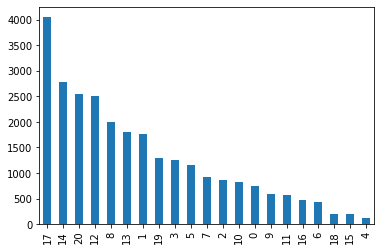

In [ ]:
# plot the frequencies of labels
df['label'].value_counts().plot(kind='bar')


In [ ]:
def parse_text(sentence):
    '''
    clean the abstract by using nltk regex tokenizer to keep only words
    input: string
    output: a list of cleaned tokens
    '''
    # convert the sentense to lower case
    sentence = sentence.lower()
    # use the nltk regex tokenizer
    # \w+ --> include only lower-case letters
    tokenizer = nltk.tokenize.RegexpTokenizer(r"[a-z]+")
    # set sentence to lower case and then pass to the tokenizer
    tokens = tokenizer.tokenize(sentence)
    # remove stop words
    stop_words = stopwords.words('english')
    tokens_without_stopwords = [w for w in tokens if w not in stop_words]
    # pad <SOS> at the start and <EOS> at the end
    tokens.insert(0, '<sos>')
    tokens.append('<eos>')
    return tokens


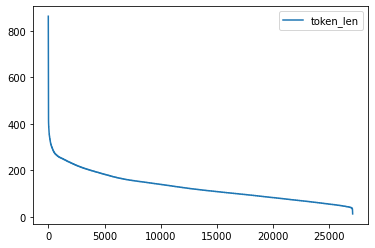

In [ ]:
# apply parse_text() on text and create a new column for the output
df['tokens'] = df['Text'].apply(parse_text)
# create a new column for the length of each token
df['token_len'] = df['tokens'].str.len()
# sort in descending order and plot to observe the length
df = df.sort_values(by='token_len', ascending=False).reset_index(drop=True)
df.plot(y='token_len')


count    27073.000000
mean       128.037196
std         62.305521
min         12.000000
25%         80.000000
50%        116.000000
75%        161.000000
max        862.000000
Name: token_len, dtype: float64 



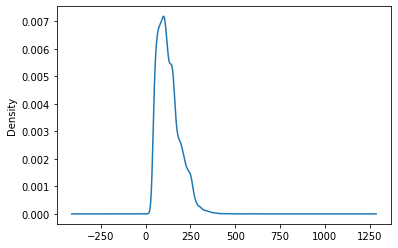

In [ ]:
# descriptive statistics and density plot for token len
# data is right skewed
print(df['token_len'].describe(), '\n')
df['token_len'].plot(kind='density')


In [ ]:
df['token_len'].quantile(.99)


305.0

In [ ]:
# number of token lists with length greater than 256
max_token_len = 256
len(df[df['token_len'] > max_token_len])


956

In [ ]:
# number of token lists with length less than 32
min_token_len = 32
len(df[df['token_len'] < min_token_len])


15

In [ ]:
# keep the rows between min and max length set above
df_trimmed = df[(df['token_len'] <= max_token_len)&
                (df['token_len'] >= min_token_len)].reset_index(drop=True)
df_trimmed.shape


(26102, 4)

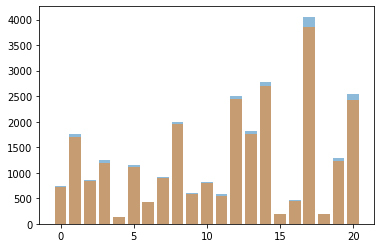

In [ ]:
# check if the dropping affects distribution of labels
x = np.arange(21)
bar1 = df['label'].value_counts().sort_index()
bar2 = df_trimmed['label'].value_counts().sort_index()
plt.bar(x, bar1, alpha=0.5)
plt.bar(x, bar2, alpha=0.5)
plt.show()


In [ ]:
# apply padding to pad the length of tokens to 512
padding = lambda x: x + ['<pad>' for _ in range(max_token_len - len(x))]
df_trimmed['tokens'] = df_trimmed['tokens'].apply(padding)
df_trimmed.head()


,label,Text,tokens,token_len
0,17,intensity-series rod and cone ergs were record...,"[<sos>, intensity, series, rod, and, cone, erg...",256
1,3,background: most transforming growth factor be...,"[<sos>, background, most, transforming, growth...",256
2,17,background: there have been many reports in th...,"[<sos>, background, there, have, been, many, r...",256
3,1,purpose: to develop a technique that achieves ...,"[<sos>, purpose, to, develop, a, technique, th...",256
4,12,the presence of spontaneous nystagmus in darkn...,"[<sos>, the, presence, of, spontaneous, nystag...",256


# 3. K-fold, train/val/test split, vocab class, and dataloader

In [ ]:
def k_fold_indices(n_folds, sample_size, test_folds):
    '''
    implement k-fold for model evaluation
    returns a list of indices of df
    '''
    index_list = [i for i in range(sample_size)]
    if sample_size%n_folds != 0:
        index_list = index_list[:-(sample_size%n_folds)]
    random.shuffle(index_list)
    fold_size = sample_size // n_folds
    # create n folds in list
    folds = []

    for i in range(n_folds):
        start = fold_size*i
        end = fold_size*(i+test_folds)
        if end <= len(index_list):
            not_train = index_list[start:end]
            train = index_list[:start] + index_list[end:]
        else:
            end -=len(index_list)
            not_train = index_list[:end] + index_list[start:]
            train = index_list[end:start]
        split = fold_size//2 * test_folds
        val = not_train[:split]
        test = not_train[split:]
        folds.append([train, val, test])
    print(f'Train sample size: {len(train)}')
    print(f'Val/test sample size: {len(val), len(test)}\n')

    return folds


def get_k_fold_data(df, indices):
    '''
    get the data from df based on indices
    output: numpy arrays of train, val, test data
    '''
    train = df.iloc[indices[0]]
    val = df.iloc[indices[1]]
    test = df.iloc[indices[2]]
    return [x.to_numpy() for x in (train, val, test)]


In [ ]:
# test k_fold
k_fold_i = k_fold_indices(5, df_trimmed.shape[0], 1)
train, val, test = get_k_fold_data(df_trimmed[['tokens', 'label', 'token_len']], k_fold_i[0])

print(train.shape, val.shape, test.shape)
print(f'sample text from train set:{train[:, 0][50][:10]}\n'
      f'sample label for the text: {train[:, 1][50]}'
      f'sample token length for the text: {train[:, 2][50]}')


Train sample size: 20880
Val/test sample size: (2610, 2610)

(20880, 3) (2610, 3) (2610, 3)
sample text from train set:['<sos>', 'severe', 'macular', 'oedema', 'causing', 'marked', 'loss', 'of', 'vision', 'is']
sample label for the text: 17sample token length for the text: 127


In [ ]:
# create the vocab class
class Vocab:
    '''
    Collects unique tokens and assign indices to the tokens.
    '''
    def __init__(self, tokens, reserved_tokens=['<sos>', '<eos>'], min_freq=0):
        # get a dictionary of unique tokens and their frequencies
        counter = count_unique(tokens)
        # sort the dictionary in descending order according to token's frequency
        self.token_freqs = sorted(
            counter.items(),
            key=lambda x: x[1],
            reverse=True)
        self.unk = 1
        # create a list of reserved tokens + unique tokens 
        uniq_tokens = ['<pad>'] + ['<unk>'] + reserved_tokens
        uniq_tokens += [
            token for token, freq in self.token_freqs
            if freq >= min_freq and token not in uniq_tokens]
        # function'index to token' and 'token to index'
        self.idx_to_token, self.token_to_idx= [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if type(tokens) == str:
            return self.token_to_idx.get(tokens, self.unk)
        return [self.token_to_idx.get(token, self.unk) for token in tokens]

    def to_tokens(self, indices):
        if type(indices) == int:
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]


def count_unique(tokens):
    '''
    Input: tokens (train[:, 0])
    Output: a dictionary with words as keys and their frequency as values
    '''
    unique_word_bag = dict()
    for lst in tokens:
        for word in lst:
            unique_word_bag[word] = unique_word_bag.get(word, 0) + 1
    return unique_word_bag


# test the vocab class: word to index
# vocab = Vocab(train[:, 0],  min_freq=1)
# vocab_size = len(vocab)
# test_idx = vocab['background', 'retinal', 'rupture', 'and', '<pad>', 'unk']
# vocab.to_tokens(test_idx)
# padding_index = vocab['<pad>']


In [ ]:
# create a class for data iterator that returns batches of data
class Dataiterator:
    '''
    Iterator that returns one batch of data at a time
    '''
    # shape of one batch of token: 
    # shape of one batch of label: (batch_size)
    def __init__(self, batch_size, dataset):
        self.batch_size = batch_size
        self.raw_dataset = dataset
        self.n_batches = len(self.raw_dataset) // self.batch_size
        self.batch = self.raw_dataset[:self.n_batches * self.batch_size, :]
        self.current_batch = 0

    def __iter__(self):
        '''
        Shuffle dataset each time when called as iter(Dataiterator)
        '''
        self.batch = self.shuffle_data(self.batch)
        return self

    def __next__(self):
        '''
        Returns on batch of data.
        x shape: (batch_size, token_lenth)
        y shape: (batch_size,)
        '''
        if self.current_batch < self.n_batches:
            start = self.current_batch * self.batch_size
            end = start + self.batch_size
            x = self.to_index(self.batch[start:end, 0])    # tokens to index
            y = self.batch[start:end, 1].astype(int)
            l = self.batch[start:end, 2].astype(int)
            self.current_batch += 1
            return torch.from_numpy(x), torch.from_numpy(y), torch.from_numpy(l)
        else:
            # stop after returned all batches
            self.current_batch = 0
            raise StopIteration
    
    def shuffle_data(self, dataset):
        return shuffle(dataset, random_state=8)
    
    def to_index(self, batch):
        '''
        Turns list of tokens into list of indices using the vocab object
        '''
        lst = []
        for i in batch:
            lst.append(vocab[i])
        return np.array(lst)

# test:
# test_iter = Dataiterator(64, train)
# token, label, token_len = next(iter(test_iter))
# token.size()


# 4. Embedding matrix based on pretrained embedding model

In [ ]:
# if word from the vocab exists in the glove embedding, use 
# the vector in embedding; otherwise initialize with uniform
# distribution from -1 to 1
def get_embed_matrix():
    from_w2v = 0
    embed_matrix = torch.zeros((vocab_size, embedding_dim)).uniform_(-1, 1)
    for idx in range(vocab_size):
        word = vocab.to_tokens(idx)
        if word in w2v:
            embed_matrix[idx] = torch.tensor(w2v[word])
            from_w2v += 1
    # print(f'Taken {from_w2v} vectors from the w2v pretrained embedding')
    return embed_matrix


# 5. Define model

The neural network is built with the following structure:<br/><br/>
Embedding layer -> GRU -> FC -> Logits<br/><br/>




In [ ]:
class RNNClassifier(nn.Module):

    def __init__(self,
                 hidden_size,
                 input_size,
                 output_size,
                 embed_dim,
                 embed_matrix,
                 dropout=0.2):
        super().__init__()
        # embedding layer with pretrained weights
        self.embedding = nn.Embedding.from_pretrained(
            embed_matrix,
            freeze=False,
            padding_idx=0)
        # gru layer with input_size=embed_dim and num_layer=1
        self.gru = nn.GRU(
            embed_dim,
            hidden_size,
            num_layers=1,
            batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x, l):
        # embedding output shape: batch_size, token_len, embed_dim
        x = self.embedding(x)
        x = self.dropout(x)
        x = pack_padded_sequence(x, l.to('cpu'),
                                 batch_first=True,
                                 enforce_sorted=False)
        _, h = self.gru(x)
        # use the last hidden state for classification and output logits
        x = self.fc(h[-1])
        return x


# 6. Define training and validation step for one epoch

Regular training and validating steps for pytorch

In [ ]:
# helper function: accuracy
def get_accuracy(pred, label):
    pred = pred.argmax(axis=1)
    correct_pred = pred==label
    return correct_pred.sum() / len(correct_pred)


In [ ]:
def train_epoch(net, train_iter, optimizer, criterion):
    net.train()
    loss = 0.0
    accuracy = 0.0
    num_batches = train_iter.n_batches

    for i, (tokens, labels, token_len) in tqdm(
        enumerate(iter(train_iter)),
        desc='Training',
        total = num_batches,
        leave=True,
        ncols=80,
        disable=True):

        tokens, labels, token_len = tokens.to(device), labels.to(device), token_len.to(device)
        optimizer.zero_grad()
        predictions = net(tokens, token_len)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        accuracy += get_accuracy(predictions, labels) / num_batches
        loss += loss.item() / num_batches
    return loss, accuracy


def valid_epoch(net, valid_iter, criterion):
    net.eval()
    loss = 0.0
    accuracy = 0.0
    num_batches = valid_iter.n_batches

    with torch.no_grad():
        for i, (tokens, labels, token_len) in tqdm(
            enumerate(iter(valid_iter)),
            desc='Validating',
            total = num_batches,
            leave=True,
            ncols=80,
            disable=True):
            tokens, labels, token_len = tokens.to(device), labels.to(device), token_len.to(device)
            predictions = net(tokens, token_len)
            loss = criterion(predictions, labels)
            accuracy += get_accuracy(predictions, labels) / num_batches
            loss += loss.item() / num_batches

    return loss, accuracy


def test_model():
    # load the model with lowest validation loss
    net.load_state_dict(torch.load(f'RNNClassifier_{i+1}_best_val_loss.pt'))
    # set batch size=1 for test
    test_iter = Dataiterator(1, test)
    test_loss1, test_acc1 = valid_epoch(net, test_iter, criterion)
    print(f'\nBest val loss model:\nTest loss: {test_loss1:.3f}   Test accuracy: {test_acc1*100:.3f}%')
    # load the model with highest accuracy
    net.load_state_dict(torch.load(f'RNNClassifier_{i+1}_best_val_acc.pt'))
    test_loss2, test_acc2 = valid_epoch(net, test_iter, criterion)
    print(f'\nBest val acc model:\nTest loss: {test_loss2:.3f}   Test accuracy: {test_acc2*100:.3f}%')
    return test_acc1, test_acc2


# 7. Set hyperparameters

In [ ]:
hidden_size = 128   # 128
output_size = 21
lr = 0.004
batch_size = 128
n_epochs = 8
dropout = 0.4    # 0.4


# 8. Train the network and implement K-fold validation

In [ ]:
n_folds = 5
num_test_fold = 1   # half for val and half for test
k_fold_i = k_fold_indices(5, df_trimmed.shape[0], 1)
best_val_test = []
best_acc_test = []

for i in range(n_folds):
    print(f'Model {i+1}:')
    train, val, test = get_k_fold_data(df_trimmed[['tokens', 'label', 'token_len']], k_fold_i[i])
    # build vocab class on the train tokens
    # replace words that appear less than 1 time with unknown
    vocab = Vocab(train[:, 0],  min_freq=1)
    vocab_size = len(vocab)
    embed_matrix = get_embed_matrix()

    net = RNNClassifier(
        hidden_size,
        vocab_size,
        output_size,
        embedding_dim,
        embed_matrix,
        dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)
    train_iter = Dataiterator(batch_size, train)
    valid_iter = Dataiterator(batch_size, val)

    best_valid_loss = 9.9
    best_valid_acc = 0.0

    for epoch in range(n_epochs):
        
        # print(f'Epoch {epoch+1:02}')
        train_loss, train_acc = train_epoch(net, train_iter, optimizer, criterion)
        valid_loss, valid_acc = valid_epoch(net, valid_iter, criterion)
        scheduler.step()

        # save the model with lowest valid loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(net.state_dict(), f'RNNClassifier_{i+1}_best_val_loss.pt')
        
        # save the model with highest valid accuracy
        # to later experiment on the test dataset
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            torch.save(net.state_dict(), f'RNNClassifier_{i+1}_best_val_acc.pt')

        # print(f'Train loss:      {train_loss:.3f}   Accuracy: {train_acc*100:.3f}%')
        # print(f'Validation loss: {valid_loss:.3f}   Accuracy: {valid_acc*100:.3f}%\n')
        time.sleep(1)

    print(f'The lowest validation loss is {best_valid_loss:.3f}')
    print(f'The highest validation accuracy is {best_valid_acc*100:.3f}%')
    test_acc1, test_acc2 = test_model()
    best_val_test.append(test_acc1)
    best_acc_test.append(test_acc2)
    print('---------------------------------------------------------------\n\n')

print(f'Best val loss model avg acc: {sum(best_val_test) / len(best_val_test) * 100:.3f}')
print(f'Best val acc model avg acc: {sum(best_acc_test) / len(best_acc_test) * 100:.3f}')


Train sample size: 20880
Val/test sample size: (2610, 2610)

Model 1:
The lowest validation loss is 0.651
The highest validation accuracy is 79.141%

Best val loss model:
Test loss: 0.002   Test accuracy: 79.348%

Best val acc model:
Test loss: 0.077   Test accuracy: 79.425%
---------------------------------------------------------------


Model 2:
The lowest validation loss is 0.538
The highest validation accuracy is 80.273%

Best val loss model:
Test loss: 0.003   Test accuracy: 79.195%

Best val acc model:
Test loss: 0.098   Test accuracy: 79.195%
---------------------------------------------------------------


Model 3:
The lowest validation loss is 0.678
The highest validation accuracy is 78.633%

Best val loss model:
Test loss: 0.015   Test accuracy: 78.620%

Best val acc model:
Test loss: 2.942   Test accuracy: 78.543%
---------------------------------------------------------------


Model 4:
The lowest validation loss is 0.778
The highest validation accuracy is 78.203%

Best va

# 9. Summary


1. The average test accuracy of the models with the best accuracy on the validation data was 79.35%, while the average test accuracy of the models with the best loss on the validation data was 79.29%. <br/><br/>

2. The dataset used for training and validation is imbalanced. There is a significant disparity in the number of samples for different classes. For example, there are approximately 4,000 samples for the 'Retinal Diseases' class, but only less than 250 samples for the 'Pupil Disorders' and 'Eye Hemorrhage' classes. This imbalance could potentially affect the accuracy of the classification model. Increasing the number of samples for these classes may improve the overall performance of the model.

In [ ]:
!pip freeze > requirements.txt